In [73]:
## Import Packages
import numpy as np  
import matplotlib.pyplot as plt
import functions as f
import seaborn as sns
import scipy.stats as sts
from scipy.optimize import fsolve
import pandas

# Chapter 2: Credit Risk Management

## Dependent Default Structure

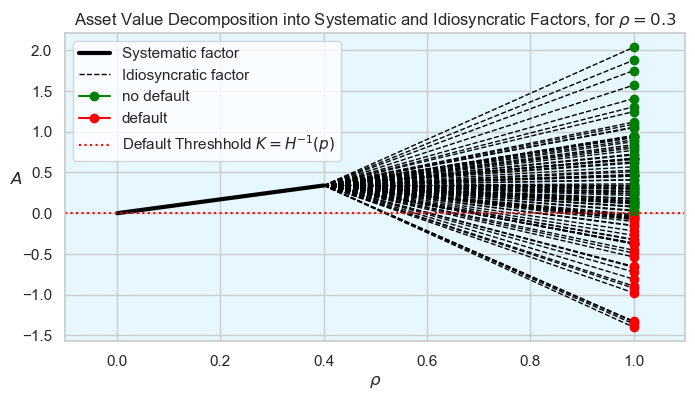

In [74]:
# Setup Parameters
nr_of_sims = 1
port_size = 100
lgd = np.ones(port_size)
ntnls = np.ones(port_size)
pd = 0.5
pds = np.ones(port_size)*pd
cor = 0.4

# Simulate factors and asset values
s, i, av = f.sim_av_gauss(cor, port_size, nr_of_sims)
av = np.squeeze(av)
s = np.squeeze(s)
i = np.squeeze(i)

# Prepare data for plot
s_data = [np.linspace(0,cor,1000), np.linspace(0, s, 1000)]
i_data = [[np.linspace(cor, 1, 1000), np.linspace(s, s + i[k])] for k in range(port_size)]
defaults = av < sts.norm.ppf(pds)


# Create a Seaborn plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
plt.subplot()
sns.lineplot(x=s_data[0], y=s_data[1], color="black", linewidth = 3, label = "Systematic factor")
def_flag = False
non_def_flag = False
for k in range(port_size):
    x_data = np.linspace(cor, 1, 1000)
    y_data = np.linspace(s, s+i[k], 1000)
     
    if k == 0:
        sns.lineplot(x=x_data, y=y_data, color = "black", linewidth = 1, label = "Idiosyncratic factor", linestyle = "dashed")
    else:
        sns.lineplot(x=x_data, y=y_data, color = "black", linewidth = 1, linestyle = "dashed")
    if defaults[k]:
        if not def_flag:
            plt.plot(1,av[k], marker = "o", color = "red", label ="default")
            def_flag = True
        else:
            plt.plot(1,av[k], marker = "o", color = "red")
    else:
        if not non_def_flag:
            plt.plot(1,av[k], marker = "o", color = "green", label ="no default")
            non_def_flag = True
        else:
            plt.plot(1,av[k], marker = "o", color = "green")
        
plt.axhline(sts.norm.ppf(pd), linestyle = "dotted", color = "red", label = "Default Threshhold $K = H^{-1}(p)$")
plt.title(r"Asset Value Decomposition into Systematic and Idiosyncratic Factors, for $\rho = 0.3$")
plt.xlim(-0.1,1.1)
plt.xlabel(r'$\rho$')
plt.ylabel('$A$', rotation=0)
plt.legend()

## Large Homogenous Portfolio Approximation

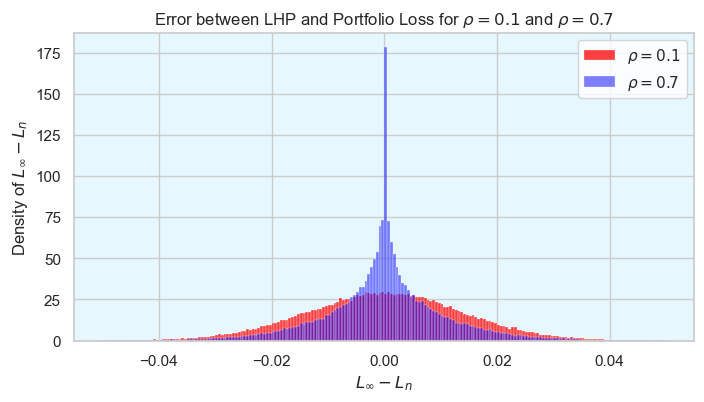

In [75]:
# Setup paramaters for two different Gaussian (LHP) Losses
nr_of_sims = 100000
port_size = 1000
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0.1
cor2 = 0.7

# Calculate Losses
s1, i, av1 = f.sim_av_gauss(cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_gauss(cor2, port_size, nr_of_sims)
losses1 = f.calc_losses_norm(av1, pd, exp_weights)
losses2 = f.calc_losses_norm(av2, pd, exp_weights)
lhp_losses1 = np.squeeze(f.cond_pd_norm(s1, pd, cor1))
lhp_losses2 = np.squeeze(f.cond_pd_norm(s2, pd, cor2))

# Generate Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
ax = sns.histplot(data=lhp_losses1-losses1, label=r"$\rho=0.1$", color="red", bins=200, binrange=(-0.05, 0.05), stat="density")
sns.histplot(data=lhp_losses2-losses2, label=r"$\rho=0.7$", color="blue", bins=200, binrange=(-0.05, 0.05),stat="density", alpha=0.5)
plt.xlabel("$L_{\infty} - L_n$")
plt.ylabel("Density of $L_{\infty} - L_n$")
plt.title(r"Error between LHP and Portfolio Loss for $\rho=0.1$ and $\rho=0.7$")
plt.legend()
plt.show()



# Chapter 3 : CDO Pricing Models

## Tranching Transformation

Text(0.5, 1.0, 'Plot of the Tranching Transformation')

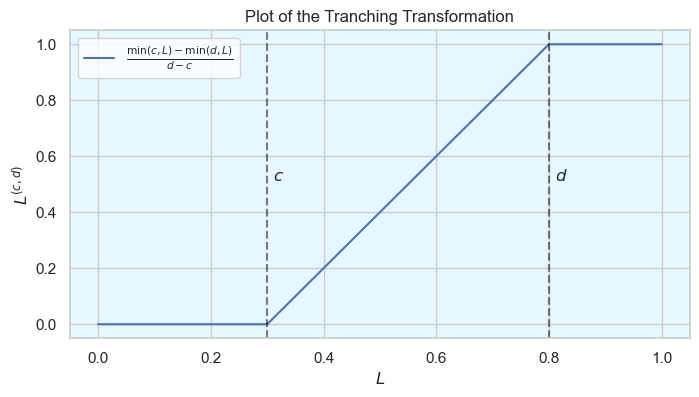

In [76]:
# Setup tranche parameters and loss domain
c = 0.3
d = 0.8
losses = np.linspace(0, 1, 1000)
tranche_losses = f.calc_tranche_losses(losses,c, d)
plot_data = pandas.DataFrame(tranche_losses, losses)

# Create Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x=losses, y=tranche_losses, label=r"$\frac{\min(c,L) - \min(d,L)}{d-c}$")
plt.axvline(c, linestyle = "dashed", color = "black", alpha = 0.5)
plt.text(c+0.01, 0.5, '$c$', rotation=0, verticalalignment='bottom')
plt.axvline(d, linestyle = "dashed", color = "black", alpha = 0.5)
plt.text(d+0.01, 0.5, '$d$', rotation=0, verticalalignment='bottom')
plt.xlabel('$L$')
plt.ylabel('$L^{(c,d)}$')
plt.title("Plot of the Tranching Transformation")

## Conditional Expectation Convergence

100-200-300-400-500-600-700-

c:\Users\cnlve\anaconda3\envs\myhive\Lib\site-packages\scipy\stats\_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


800-900-

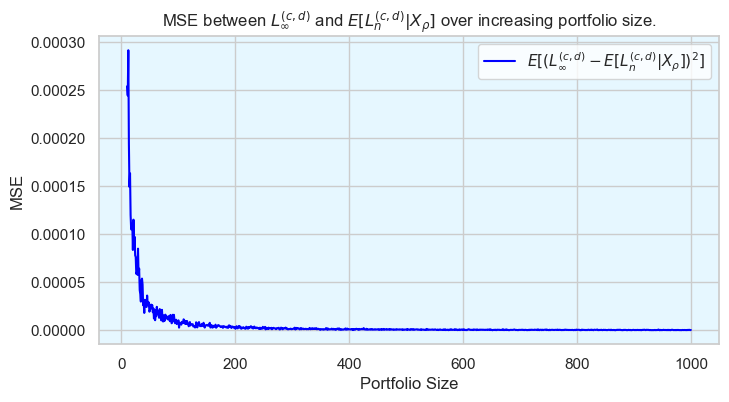

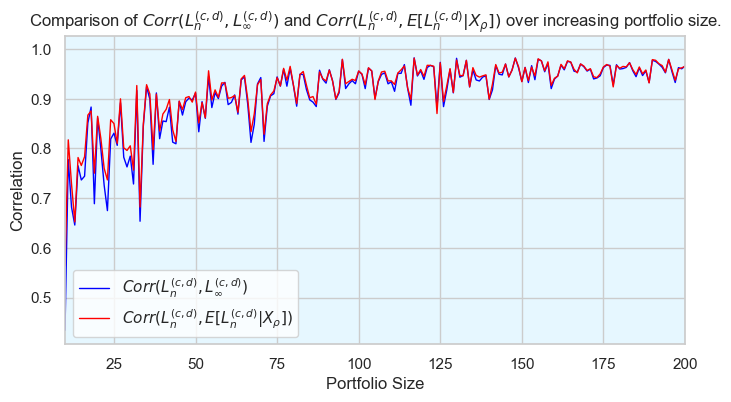

In [77]:
# Setup Parameters
pd = 0.1
cor = 0.3
c = 0.4
d = 1

# Initialise empty lists to fill with data
tranche_losses = []
lhp_tranche_losses = []
cond_exp_losses = []
mse = []
corr_lhp_tranche = []
corr_cond_exp = []

# Iterate over portfolio size
for p_size in range(10, 1000, 1):
    batch_size = 1000 # Batch size used to estimate MSE and corr
    # Setup Parameters
    exp_weights = np.ones(p_size)/p_size
    pds = np.ones(p_size)*pd
    s, i, av = f.sim_av_gauss(cor, p_size, batch_size)
    loss = f.calc_losses_norm(av, pd, exp_weights)
    tranche_loss = f.calc_tranche_losses(loss, c, d)
    lhp_loss = f.cond_pd_norm(s, pd, cor)
    lhp_tranche_loss = f.calc_tranche_losses(lhp_loss, c, d)
    cond_pd = np.squeeze(f.cond_pd_norm(s, pd, cor))

    # Compute \E[\min(c,L_n)|X_{\rho}] using brute force
    binom_p = np.mat(cond_pd)
    binom_n = p_size
    eval_points = np.mat(np.arange(binom_n+1)).T
    pmfs = sts.binom.pmf(eval_points, binom_n, binom_p)
    pmfs_tranche = pmfs[:int(np.floor(binom_n*c))+1, :]
    eval_points_tranche = np.tile(eval_points, (1, batch_size))[:int(np.floor(binom_n*c))+1, :]
    cond_exp_part1 = np.sum(np.multiply(pmfs_tranche,eval_points_tranche), axis=0)
    cond_exp_part2 = c * np.sum(pmfs[int(np.floor(binom_n*c))+1:, :], axis = 0)
    cond_exp = cond_exp_part1 /binom_n + cond_exp_part2
    cond_exp_c = np.squeeze(np.array(cond_exp))

    # Compute \E[\min(d,L_n)|X_{\rho}] using brute force
    binom_p = np.mat(cond_pd)
    binom_n = p_size
    eval_points = np.mat(np.arange(binom_n+1)).T
    pmfs = sts.binom.pmf(eval_points, binom_n, binom_p)
    pmfs_tranche = pmfs[:int(np.floor(binom_n*d))+1, :]
    eval_points_tranche = np.tile(eval_points, (1, batch_size))[:int(np.floor(binom_n*d))+1, :]
    cond_exp_part1 = np.sum(np.multiply(pmfs_tranche,eval_points_tranche), axis=0)
    cond_exp_part2 = d * np.sum(pmfs[int(np.floor(binom_n*d))+1:, :], axis = 0)
    cond_exp = cond_exp_part1 /binom_n + cond_exp_part2
    cond_exp_d = np.squeeze(np.array(cond_exp))
    tranche_loss = np.squeeze(tranche_loss)
    lhp_tranche_loss = np.squeeze(lhp_tranche_loss)

    # Compute \E[L_n^{(c,d)}|X_{\rho}]
    cond_exp_loss = np.squeeze((cond_exp_d - cond_exp_c)/(d-c))
    # Compute MSE with L_{\infty}^{(c,d)}
    mse.append( ( (lhp_tranche_loss - cond_exp_loss)**2 ).mean() )
    # Compute correlation between with L_{\infty}^{(c,d)} and L_n^{(c,d)}
    corr_lhp_tranche.append(np.corrcoef(tranche_loss, lhp_tranche_loss)[0,1])
    # Compute correlation between with \E[L_n^{(c,d)}|X_{\rho}] and L_n^{(c,d)}
    corr_cond_exp.append(np.corrcoef(tranche_loss, cond_exp_loss)[0,1])
    if np.mod(p_size, 100) == 0:
        print(p_size, end="-")

# Transform lists into arrays
mse = np.array(mse)
corr_lhp_tranche = np.array(corr_lhp_tranche)
corr_cond_exp = np.array(corr_cond_exp)

# Show MSE Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
ax = sns.lineplot(x = range(10, 1000, 1), y=mse, label=r"$E[(L_{\infty}^{(c,d)} - E[L_n^{(c,d)}|X_{\rho}])^2]$", color="blue")
plt.xlabel("Portfolio Size")
plt.ylabel("MSE")
plt.title(r"MSE between $L_{\infty}^{(c,d)}$ and $E[L_n^{(c,d)}|X_{\rho}]$ over increasing portfolio size.")
plt.legend()
plt.show()

# Show Correlation Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)
sns.lineplot(x = range(10, 1000, 1), y=corr_lhp_tranche, label=r"$Corr(L_n^{(c,d)}, L_{\infty}^{(c,d)})$", color="blue", linewidth = 1)
sns.lineplot(x = range(10, 1000, 1), y=corr_cond_exp, label=r"$Corr(L_n^{(c,d)}, E[L_n^{(c,d)}|X_{\rho}])$", color="red", linewidth = 1)
plt.xlabel("Portfolio Size")
plt.ylabel("Correlation")
plt.title(r"Comparison of $Corr(L_n^{(c,d)}, L_{\infty}^{(c,d)})$ and $Corr(L_n^{(c,d)},E[L_n^{(c,d)}|X_{\rho}])$ over increasing portfolio size.")
plt.xlim(10, 200)
plt.legend()
plt.show()



# Chapter 5: Numerical Analysis

## Gaussian Loss Density

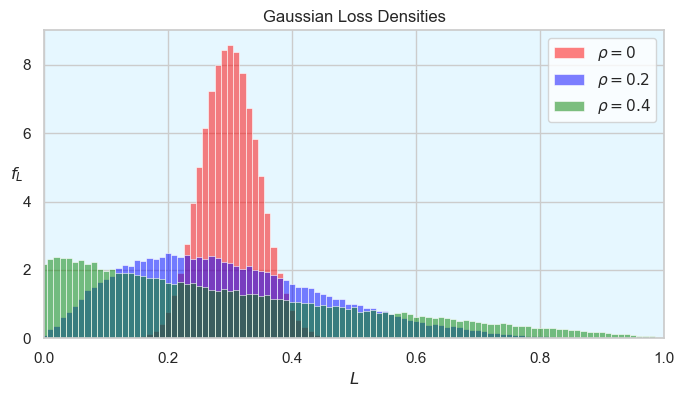

In [78]:
#  Setup paramaters for three different Gaussian Loss PDFs
nr_of_sims = 100000
port_size = 100
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0
cor2 = 0.2
cor3 = 0.4
s1, i, av1 = f.sim_av_gauss(cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_gauss(cor2, port_size, nr_of_sims)
s3, i, av3 = f.sim_av_gauss(cor3, port_size, nr_of_sims)
losses1 = f.calc_losses_norm(av1, pd, exp_weights)
losses2 = f.calc_losses_norm(av2, pd, exp_weights)
losses3 = f.calc_losses_norm(av3, pd, exp_weights)

# Generate Plots
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
bins = np.arange(-0.005, 1.01, 0.01) 
binrange = (-0.5, 1.5)
sns.histplot(data=losses1, label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses2, label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses3, label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)
plt.xlabel(r"$L$")
plt.ylabel(r"$f_L$", rotation=0)
plt.xlim(0, 1)
plt.legend()
plt.title("Gaussian Loss Densities")
plt.show()

## Shifted Gamma Loss, Systematic Factor PDF

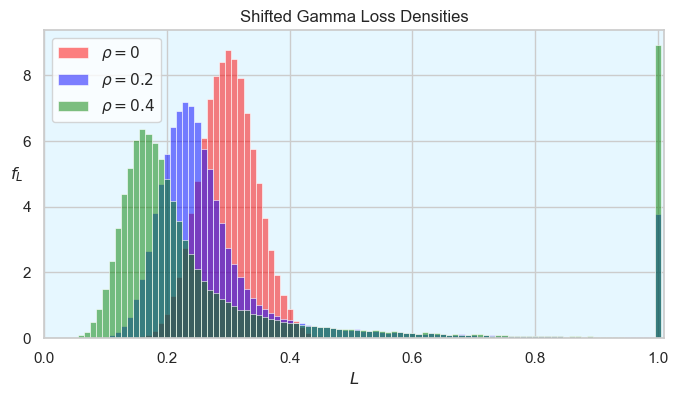

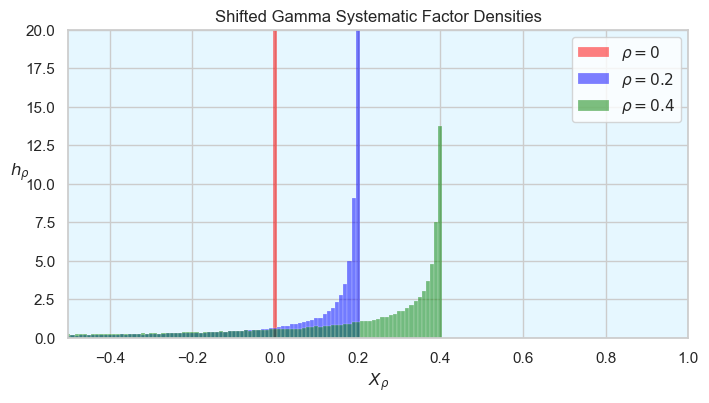

In [79]:
#  Setup paramaters for three different Shifted Gamma Loss PDFs
nr_of_sims = 100000
port_size = 100
a = 1
exp_weights = np.ones(port_size)/port_size
pd = 0.3
pds = np.ones(port_size)*pd
cor1 = 0
cor2 = 0.2
cor3 = 0.4
s1, i, av1 = f.sim_av_shifted_gamma(a, cor1, port_size, nr_of_sims)
s2, i, av2 = f.sim_av_shifted_gamma(a, cor2, port_size, nr_of_sims)
s3, i, av3 = f.sim_av_shifted_gamma(a, cor3, port_size, nr_of_sims)
losses1 = f.calc_losses_sg(av1, a, pd, exp_weights)
losses2 = f.calc_losses_sg(av2, a, pd, exp_weights)
losses3 = f.calc_losses_sg(av3, a, pd, exp_weights)

# Show Loss PDF Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
bins = np.arange(-0.005, 1.01, 0.01)
binrange = (-0.5, 1.5)
sns.histplot(data=losses1, label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses2, label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=losses3, label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)
plt.xlabel(r"$L$")
plt.ylabel(r"$f_L$", rotation=0)
plt.xlim(0, 1.01)
plt.legend()
plt.title("Shifted Gamma Loss Densities")
plt.show()

# Show Systematic Factor PDF Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
bins = np.arange(-2.005, 1.005, 0.01)
binrange = (-0.5, 1.5)
sns.histplot(data=s1[0], label=r"$\rho=0$", color="red", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=s2[0], label=r"$\rho=0.2$", color="blue", bins=bins, binrange=binrange, stat="density", alpha=0.5)
sns.histplot(data=s3[0], label=r"$\rho=0.4$", color="green", bins=bins, binrange=binrange, stat="density", alpha=0.5)
plt.xlabel(r"$X_{\rho}$")
plt.ylabel(r"$h_{\rho}$", rotation=0)
plt.xlim(-0.5, 1)
plt.ylim(0, 20)
plt.legend()
plt.title("Shifted Gamma Systematic Factor Densities")
plt.show()

## Shifted Gamma Conditional PD

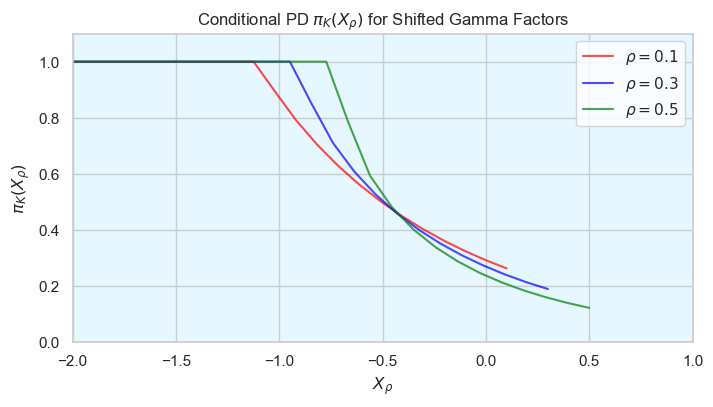

In [80]:
# Setup Parameters for conditional PD
cor1 = 0.1
cor2 = 0.3
cor3 = 0.5
x_domain1 = np.linspace(-10, cor1, 100)
x_domain2 = np.linspace(-10, cor2, 100)
x_domain3 = np.linspace(-10, cor3, 100)
y1 = f.cond_pd_sg(x_domain1, a, pd, cor1)
y2 = f.cond_pd_sg(x_domain2, a, pd, cor2)
y3 = f.cond_pd_sg(x_domain3, a, pd, cor3)

# Show Plot
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x=x_domain1, y=y1, label=r"$\rho = 0.1$", color="red", alpha = 0.7)
sns.lineplot(x=x_domain2, y=y2, label=r"$\rho = 0.3$", color="blue", alpha = 0.7)
sns.lineplot(x=x_domain3, y=y3, label=r"$\rho = 0.5$", color="green", alpha = 0.7)
plt.xlabel(r"$X_{\rho}$")
plt.ylabel(r"$\pi_K(X_{\rho})$")
plt.xlim(-2, 1)
plt.ylim(0, 1.1)
plt.legend()
plt.title(r"Conditional PD $\pi_K(X_{\rho})$ for Shifted Gamma Factors")
plt.show()

## Homogenous Portfolio Analysis

### Parameters

In [81]:
# Setup Parameters
seed = 163
nr_of_sims = 100000
nr_of_scens = 100
port_size = 100
a = 1
exp_weights_hom = np.ones(port_size)/port_size
pd = 0.1
pds = np.reshape(np.ones(port_size)*pd, (1, port_size))
cor = 0.3
c = 0.4

### Overall Performance

In [82]:
# Gaussian overall performance
np.random.seed(seed)
corrs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # Correlation choices
cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]          # Attachment Points
corr_tranch_table_gauss = np.zeros(shape=(7, 7))
corr_tranch_table_sg = np.zeros(shape=(7, 7))

gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, c)
sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, c, 1)
print("Gaussian: ", end = " ")
for i in range(7):
    for j in range(7):
        corr = corrs[i]
        cc = cs[j]
        _, _, est_corr, _ = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, corr, cc, gauss_tlhp_mean_exact)
        if -1 < est_corr < 1:
            corr_tranch_table_gauss[i,j] = 1 / np.sqrt(1 - est_corr**2)
        else:
            corr_tranch_table_gauss[i,j] = np.NAN
    print(".",end=".")


print(" ")

# Shifted gamma overall performance
print("shifted gamma: ", end = " ")
corr_tranch_table = np.zeros(shape=(7, 7))
for i in range(7):
    for j in range(7):
        corr = corrs[i]
        cc = cs[j]
        _, _, est_corr, _ = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, corr, cc, sg_tlhp_mean_exact)
        if -1 < est_corr < 1:
            corr_tranch_table_sg[i,j] = 1 / np.sqrt(1 - est_corr**2)
        else:
            corr_tranch_table_sg[i,j] = np.inf
    print(".",end=".")


# Print results 
print("Gaussian results")
for i in range(7):
    print("\\textbf{} &")
    for j in range(7):
        if j == 6:
            print(str(round(corr_tranch_table_gauss[i,j],2)) + " \\\ ")
        else:
            print(str(round(corr_tranch_table_gauss[i,j],2)) + " & ", end = "")
    print(" ")

print("shifted gamma results")
for i in range(7):
    print("\\textbf{} &")
    for j in range(7):
        if j == 6:
            print(str(round(corr_tranch_table_sg[i,j],2)) + " \\\ ")
        else:
            print(str(round(corr_tranch_table_sg[i,j],2)) + " & ", end = "")
    print(" ")



Gaussian:  .............. 
shifted gamma:  ..............Gaussian results
\textbf{} &
2.07 & 1.73 & 1.43 & 1.32 & 1.0 & 1.0 & 1.0 \\ 
 
\textbf{} &
2.95 & 2.61 & 2.37 & 2.13 & 1.9 & 1.68 & 1.36 \\ 
 
\textbf{} &
3.78 & 3.48 & 3.17 & 2.89 & 2.43 & 2.33 & 2.09 \\ 
 
\textbf{} &
4.67 & 4.32 & 3.99 & 3.67 & 3.25 & 2.91 & 2.58 \\ 
 
\textbf{} &
5.67 & 5.31 & 4.92 & 4.55 & 4.17 & 3.67 & 3.34 \\ 
 
\textbf{} &
6.65 & 6.28 & 5.9 & 5.35 & 5.02 & 4.54 & 3.83 \\ 
 
\textbf{} &
8.04 & 7.61 & 7.16 & 6.64 & 6.13 & 5.47 & 4.92 \\ 
 
shifted gamma results
\textbf{} &
4.64 & 8.61 & 9.66 & 10.44 & 11.24 & 12.78 & 13.57 \\ 
 
\textbf{} &
6.76 & 9.8 & 10.54 & 12.25 & 12.81 & 14.07 & 13.38 \\ 
 
\textbf{} &
8.41 & 10.99 & 12.45 & 13.56 & 14.25 & 14.81 & 17.79 \\ 
 
\textbf{} &
10.16 & 12.55 & 13.83 & 15.62 & 16.28 & 18.14 & 20.63 \\ 
 
\textbf{} &
11.86 & 14.67 & 16.16 & 18.1 & 20.32 & 22.45 & 25.22 \\ 
 
\textbf{} &
14.21 & 17.12 & 20.35 & 23.38 & 26.82 & 28.99 & 35.3 \\ 
 
\textbf{} &
17.83 & 21.56 & 26.

### Portfolio size analysis

In [83]:
# Set seed and range
np.random.seed(seed)
port_size_range = np.linspace(10, 1010, nr_of_scens, dtype=int) # Set range

# Initialise data
mc_ests_gauss_port = []
mc_ests_stds_gauss_port = []
mc_cv_ests_gauss_port = []
mc_cv_corrs_gauss_port = []

mc_ests_sg_port = []
mc_ests_stds_sg_port = []
mc_cv_ests_sg_port = []
mc_cv_corrs_sg_port = []


gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, c)
sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, c, 1)
for p_size in port_size_range:
    # Setup parameters
    pds_ps = np.reshape(np.ones(p_size)*pd, (1, p_size))
    exp_weights_ps = np.ones(p_size)/p_size

    # Gaussian 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(10000, p_size, pds_ps, exp_weights_ps, cor, c, gauss_tlhp_mean_exact)
    mc_ests_gauss_port.append(mc_est_gauss)
    mc_ests_stds_gauss_port.append(mc_est_std_gauss)
    mc_cv_ests_gauss_port.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_port.append(est_corr_gauss)

    # SG
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(10000, p_size, a, pds_ps, exp_weights_ps, cor, c, sg_tlhp_mean_exact)
    mc_ests_sg_port.append(mc_est_sg)
    mc_ests_stds_sg_port.append(mc_est_std_sg)
    mc_cv_ests_sg_port.append(mc_cv_est_sg)
    mc_cv_corrs_sg_port.append(est_corr_sg)

    # Loading Bar
    if np.mod(p_size, 10) == 0:
        print(p_size, end="-")

# Convert to arrays
mc_ests_gauss_port = np.array(mc_ests_gauss_port)
mc_ests_stds_gauss_port = np.array(mc_ests_stds_gauss_port)
mc_cv_ests_gauss_port = np.array(mc_cv_ests_gauss_port)
mc_cv_corrs_gauss_port = np.array(mc_cv_corrs_gauss_port)
mc_ests_sg_port = np.array(mc_ests_sg_port)
mc_ests_stds_sg_port = np.array(mc_ests_stds_sg_port)
mc_cv_ests_sg_port = np.array(mc_cv_ests_sg_port)
mc_cv_corrs_sg_port = np.array(mc_cv_corrs_sg_port)

10-20-30-40-50-60-70-80-90-100-1010-

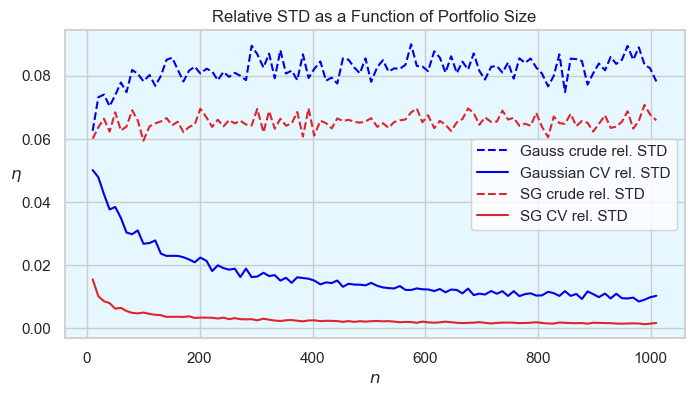

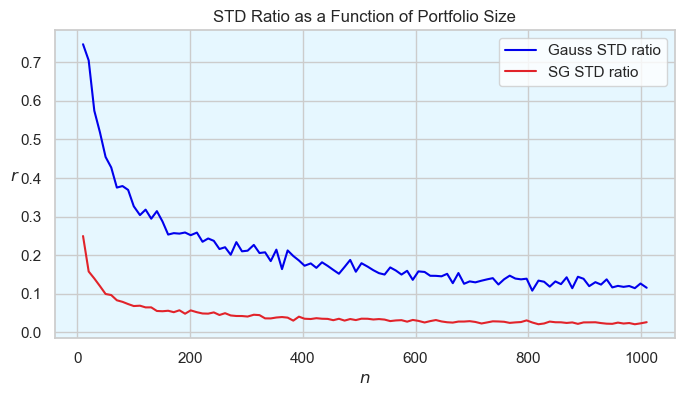

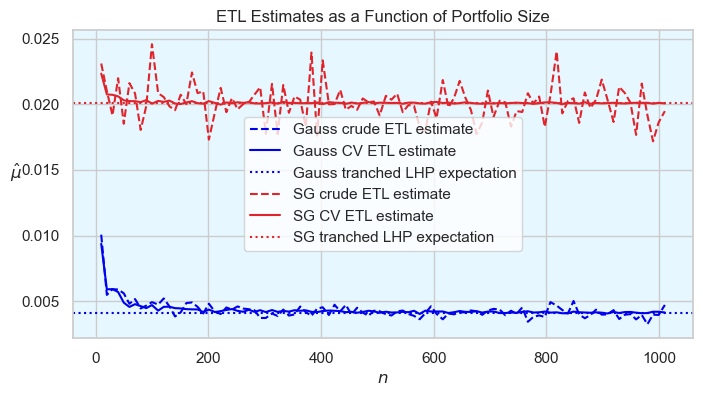

In [84]:
# Generate plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = port_size_range, y = mc_ests_stds_gauss_port/mc_ests_gauss_port, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_ests_stds_gauss_port * np.sqrt(1 - mc_cv_corrs_gauss_port**2) / mc_cv_ests_gauss_port, label="Gaussian CV rel. STD", color='#0000EC')
sns.lineplot(x = port_size_range, y = mc_ests_stds_sg_port/mc_ests_sg_port, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_ests_stds_sg_port * np.sqrt(1 - mc_cv_corrs_sg_port**2) / mc_cv_ests_sg_port, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$n$")
plt.title("Relative STD as a Function of Portfolio Size")
plt.legend()
plt.show()

# Generate plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = port_size_range, y = np.sqrt(1 - mc_cv_corrs_gauss_port**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = port_size_range, y = np.sqrt(1 - mc_cv_corrs_sg_port**2), label="SG STD ratio", color='#E1232A')
plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$n$")
plt.title("STD Ratio as a Function of Portfolio Size")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = port_size_range, y = mc_ests_gauss_port, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_cv_ests_gauss_port, label="Gauss CV ETL estimate", color='#0000EC')
plt.axhline(gauss_tlhp_mean_exact,label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = port_size_range, y = mc_ests_sg_port, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = port_size_range, y = mc_cv_ests_sg_port, label="SG CV ETL estimate", color='#E1232A')
plt.axhline(sg_tlhp_mean_exact,label= "SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$n$")
plt.title("ETL Estimates as a Function of Portfolio Size")
plt.legend()
plt.show()

### PD

In [85]:
# Set seed and range
np.random.seed(seed)
pd_range = np.linspace(0.001, 0.2, nr_of_scens)\

# Initialise data
mc_ests_gauss_PD = []
mc_ests_stds_gauss_PD = []
mc_cv_ests_gauss_PD = []
mc_cv_corrs_gauss_PD = []
tranche_lhp_exact_gauss_PD = []

mc_ests_sg_PD = []
mc_ests_stds_sg_PD = []
mc_cv_ests_sg_PD = []
mc_cv_corrs_sg_PD = []
tranche_lhp_exact_sg_PD = []

for p in pd_range:
    # Setup parameters
    pds_p = np.reshape(np.ones(port_size)*p, (1, port_size))

    #Gaussian
    gauss_lhp_mean_exact = f.tranched_lhp_expect_norm_hom(p, cor, c)
    tranche_lhp_exact_gauss_PD.append(gauss_lhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds_p, exp_weights_hom, cor, c, gauss_lhp_mean_exact)
    mc_ests_gauss_PD.append(mc_est_gauss)
    mc_ests_stds_gauss_PD.append(mc_est_std_gauss)
    mc_cv_ests_gauss_PD.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_PD.append(est_corr_gauss)

    #SG
    sg_lhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, p, cor, c, 1)
    tranche_lhp_exact_sg_PD.append(sg_lhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds_p, exp_weights_hom, cor, c, sg_lhp_mean_exact)
    mc_ests_sg_PD.append(mc_est_sg)
    mc_ests_stds_sg_PD.append(mc_est_std_sg)
    mc_cv_ests_sg_PD.append(mc_cv_est_sg)
    mc_cv_corrs_sg_PD.append(est_corr_sg)
    if np.mod(round(p*100), 2) == 0:
        print(p, end="-")

# transform to arrays
mc_ests_gauss_PD = np.array(mc_ests_gauss_PD)
mc_ests_stds_gauss_PD = np.array(mc_ests_stds_gauss_PD)
mc_cv_ests_gauss_PD = np.array(mc_cv_ests_gauss_PD)
mc_cv_corrs_gauss_PD = np.array(mc_cv_corrs_gauss_PD)
tranche_lhp_exact_gauss_PD = np.array(tranche_lhp_exact_gauss_PD)
mc_ests_sg_PD = np.array(mc_ests_sg_PD)
mc_ests_stds_sg_PD = np.array(mc_ests_stds_sg_PD)
mc_cv_ests_sg_PD = np.array(mc_cv_ests_sg_PD)
mc_cv_corrs_sg_PD = np.array(mc_cv_corrs_sg_PD)
tranche_lhp_exact_sg_PD = np.array(tranche_lhp_exact_sg_PD)


0.001-0.00301010101010101-0.015070707070707071-0.017080808080808082-0.019090909090909092-0.021101010101010103-0.023111111111111114-0.03517171717171717-0.037181818181818184-0.039191919191919194-0.041202020202020205-0.043212121212121216-0.05527272727272727-0.05728282828282828-0.05929292929292929-0.061303030303030304-0.06331313131313131-0.07537373737373737-0.07738383838383839-0.07939393939393939-0.08140404040404041-0.08341414141414141-0.09547474747474748-0.09748484848484848-0.0994949494949495-0.1015050505050505-0.10351515151515152-0.11557575757575758-0.11758585858585859-0.1195959595959596-0.1216060606060606-0.12361616161616162-0.13567676767676767-0.1376868686868687-0.1396969696969697-0.1417070707070707-0.14371717171717172-0.1557777777777778-0.15778787878787878-0.1597979797979798-0.16180808080808082-0.1638181818181818-0.17587878787878788-0.1778888888888889-0.1798989898989899-0.1819090909090909-0.18391919191919193-0.19597979797979798-0.197989898989899-0.2-

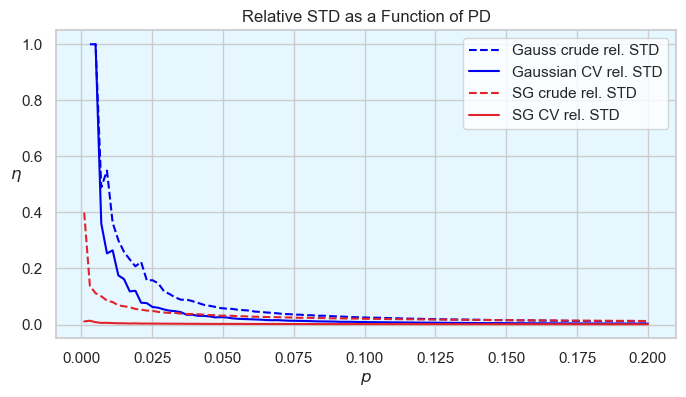

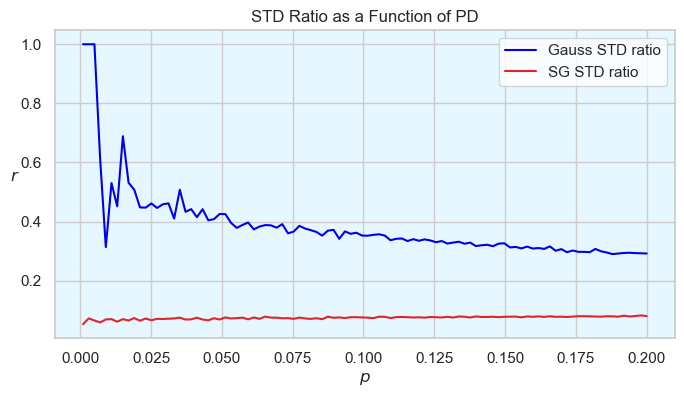

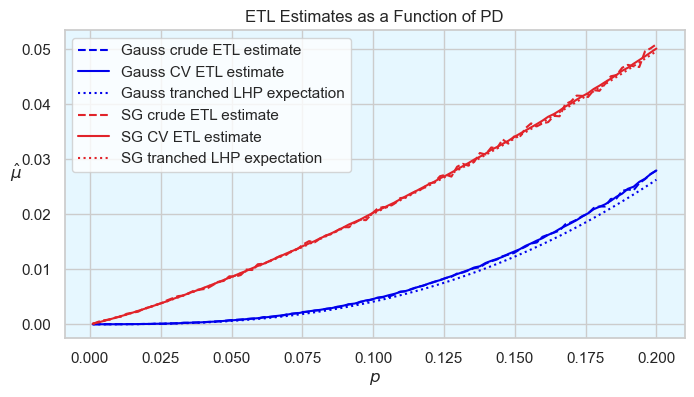

In [86]:
# Generate Plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD/mc_ests_gauss_PD, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_ests_stds_gauss_PD * np.sqrt(1 - mc_cv_corrs_gauss_PD**2) / mc_cv_ests_gauss_PD, label="Gaussian CV rel. STD", color='#0000EC')
sns.lineplot(x = pd_range, y = mc_ests_stds_sg_PD/mc_ests_sg_PD, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_ests_stds_sg_PD * np.sqrt(1 - mc_cv_corrs_sg_PD**2) / mc_cv_ests_sg_PD, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$p$")
plt.title("Relative STD as a Function of PD")
plt.legend()
plt.show()

# Generate Plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
sns.lineplot(x = pd_range, y = np.sqrt(1 - mc_cv_corrs_gauss_PD**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = pd_range, y = np.sqrt(1 - mc_cv_corrs_sg_PD**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$p$")
plt.title("STD Ratio as a Function of PD")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)

sns.lineplot(x = pd_range, y = mc_ests_gauss_PD, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_cv_ests_gauss_PD, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=pd_range, y=tranche_lhp_exact_gauss_PD, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = pd_range, y = mc_ests_sg_PD, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = pd_range, y = mc_cv_ests_sg_PD, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=pd_range, y=tranche_lhp_exact_sg_PD, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$p$")
plt.title("ETL Estimates as a Function of PD")
plt.legend()
plt.show()

### Tranche Seniority

In [87]:
# Set seed and range
np.random.seed(seed)
c_range = np.linspace(0, 0.9, nr_of_scens)  # Set range

# Initialize data
mc_ests_gauss_sen = []
mc_ests_stds_gauss_sen = []
mc_cv_ests_gauss_sen = []
mc_cv_corrs_gauss_sen = []
tranche_lhp_exact_gauss_sen = []

mc_ests_sg_sen = []
mc_ests_stds_sg_sen = []
mc_cv_ests_sg_sen = []
mc_cv_corrs_sg_sen = []
tranche_lhp_exact_sg_sen = []
for cc in c_range:

    #Gaussian
    gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, cor, cc)
    tranche_lhp_exact_gauss_sen.append(gauss_tlhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, cor, cc, gauss_tlhp_mean_exact)
    mc_ests_gauss_sen.append(mc_est_gauss)    
    mc_ests_stds_gauss_sen.append(mc_est_std_gauss)
    mc_cv_ests_gauss_sen.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_sen.append(est_corr_gauss)

    #SG
    sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, cor, cc, 1)
    tranche_lhp_exact_sg_sen.append(sg_tlhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, cor, cc, sg_tlhp_mean_exact)
    mc_ests_sg_sen.append(mc_est_sg)
    mc_ests_stds_sg_sen.append(mc_est_std_sg)
    mc_cv_ests_sg_sen.append(mc_cv_est_sg)
    mc_cv_corrs_sg_sen.append(est_corr_sg)

    # Loading Bar
    if np.mod(cc*100, 5) == 0:
        print(cc, end="-")

# Transform into arrays
mc_ests_gauss_sen = np.array(mc_ests_gauss_sen)
mc_ests_stds_gauss_sen = np.array(mc_ests_stds_gauss_sen)
mc_cv_ests_gauss_sen = np.array(mc_cv_ests_gauss_sen)
mc_cv_corrs_gauss_sen = np.array(mc_cv_corrs_gauss_sen)
tranche_lhp_exact_gauss_sen = np.array(tranche_lhp_exact_gauss_sen)

mc_ests_sg_sen = np.array(mc_ests_sg_sen)
mc_ests_stds_sg_sen = np.array(mc_ests_stds_sg_sen)
mc_cv_ests_sg_sen = np.array(mc_cv_ests_sg_sen)
mc_cv_corrs_sg_sen = np.array(mc_cv_corrs_sg_sen)
tranche_lhp_exact_sg_sen = np.array(tranche_lhp_exact_sg_sen)

0.0-0.09999999999999999-0.19999999999999998-0.3-0.39999999999999997-0.5-0.6-0.7-0.7999999999999999-0.9-

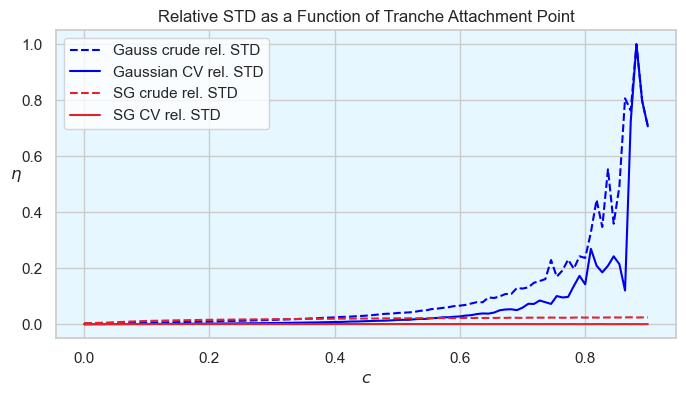

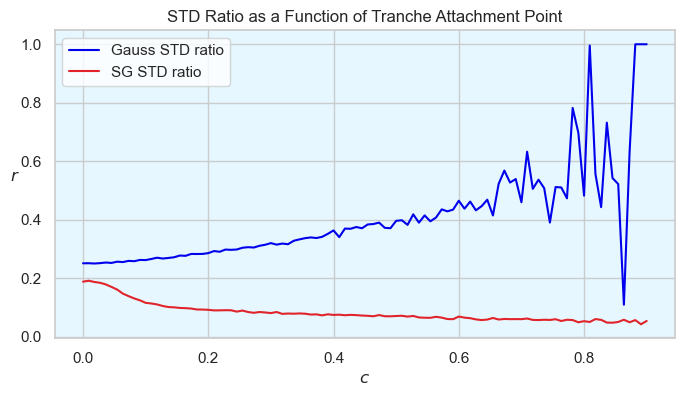

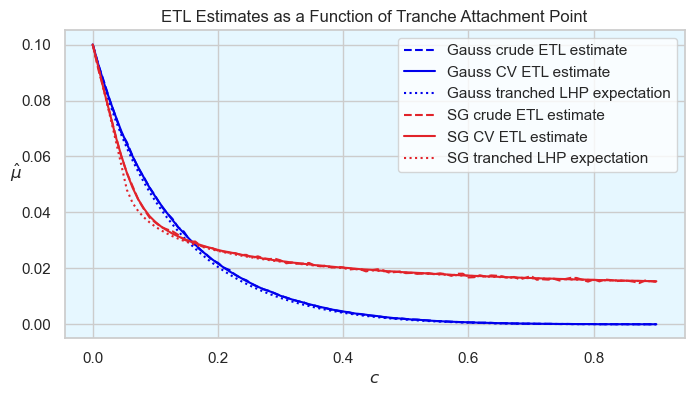

In [88]:
# Generate Plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen/mc_ests_gauss_sen, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_ests_stds_gauss_sen * np.sqrt(1 - mc_cv_corrs_gauss_sen**2) / mc_cv_ests_gauss_sen, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = c_range, y = mc_ests_stds_sg_sen/mc_ests_sg_sen, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_ests_stds_sg_sen * np.sqrt(1 - mc_cv_corrs_sg_sen**2) / mc_cv_ests_sg_sen, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$c$")
plt.title("Relative STD as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

# Generate Plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = np.sqrt(1 - mc_cv_corrs_gauss_sen**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = c_range, y = np.sqrt(1 - mc_cv_corrs_sg_sen**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
plt.title("STD Ratio as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  # Use a gray shade (0.8 for light gray)
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'  # You can specify the color using a hex code or color name
plt.gca().set_facecolor(background_color)

sns.lineplot(x = c_range, y = mc_ests_gauss_sen, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_cv_ests_gauss_sen, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=c_range, y=tranche_lhp_exact_gauss_sen, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = mc_ests_sg_sen, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = mc_cv_ests_sg_sen, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=c_range, y=tranche_lhp_exact_sg_sen, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
plt.title("ETL Estimates as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

### Asset Correlation

In [89]:
# Set Seed and Range
np.random.seed(seed)
cor_range = np.linspace(0.001, 0.999, nr_of_scens)

# Initialize Data
mc_ests_gauss_cor = []
mc_ests_stds_gauss_cor = []
mc_cv_ests_gauss_cor = []
mc_cv_corrs_gauss_cor = []
tranche_lhp_exact_gauss_cor = []

mc_ests_sg_cor = []
mc_ests_stds_sg_cor = []
mc_cv_ests_sg_cor = []
mc_cv_corrs_sg_cor = []
tranche_lhp_exact_sg_cor = []

for crrltn in cor_range:

    #Gaussian
    gauss_tlhp_mean_exact = f.tranched_lhp_expect_norm_hom(pd, crrltn, c)
    tranche_lhp_exact_gauss_cor.append(gauss_tlhp_mean_exact) 
    mc_est_gauss, mc_cv_est_gauss, est_corr_gauss, mc_est_std_gauss = f.produce_estimates_gauss_hom(nr_of_sims, port_size, pds, exp_weights_hom, crrltn, c, gauss_tlhp_mean_exact)
    print(mc_est_gauss - mc_cv_est_gauss)
    mc_ests_gauss_cor.append(mc_est_gauss)
    mc_ests_stds_gauss_cor.append(mc_est_std_gauss)
    mc_cv_ests_gauss_cor.append(mc_cv_est_gauss)
    mc_cv_corrs_gauss_cor.append(est_corr_gauss)

    #SG
    sg_tlhp_mean_exact = f.tranched_lhp_expect_sg_hom(a, pd, crrltn, c, 1)
    tranche_lhp_exact_sg_cor.append(sg_tlhp_mean_exact)
    mc_est_sg, mc_cv_est_sg, est_corr_sg, mc_est_std_sg = f.produce_estimates_sg_hom(nr_of_sims, port_size, a, pds, exp_weights_hom, crrltn, c, sg_tlhp_mean_exact)
    mc_ests_sg_cor.append(mc_est_sg)
    mc_ests_stds_sg_cor.append(mc_est_std_sg)
    mc_cv_ests_sg_cor.append(mc_cv_est_sg)
    mc_cv_corrs_sg_cor.append(est_corr_sg)

    # Loading Bar
    if np.mod(crrltn*100, 5) == 0:
        print(crrltn, end="-")

# Transform into arrays
mc_ests_gauss_cor = np.array(mc_ests_gauss_cor)
mc_ests_stds_gauss_cor = np.array(mc_ests_stds_gauss_cor)
mc_cv_ests_gauss_cor = np.array(mc_cv_ests_gauss_cor)
mc_cv_corrs_gauss_cor = np.array(mc_cv_corrs_gauss_cor)

mc_ests_sg_cor = np.array(mc_ests_sg_cor)
mc_ests_stds_sg_cor = np.array(mc_ests_stds_sg_cor)
mc_cv_ests_sg_cor = np.array(mc_cv_ests_sg_cor)
mc_cv_corrs_sg_cor = np.array(mc_cv_corrs_sg_cor)
tranche_lhp_exact_sg_cor = np.array(tranche_lhp_exact_sg_cor)

0.0
0.0
0.0
0.0
0.0
0.0
-2.0884982436115367e-06
3.4727441321055405e-07
7.284258370165079e-07
-1.3689334221054285e-06
-6.842270831782687e-06
2.7749881923370523e-06
1.9099985896212828e-07
1.910309299822682e-05
-4.6933588494487495e-06
2.556545825639536e-06
-9.108459596396065e-06
-2.1506800749478247e-05
-2.260412181655691e-06
-1.1283293289800168e-05
4.515095146288492e-06
7.772756578495674e-06
-5.6916674657686225e-05
0.00010473085727657734
3.066987625602183e-05
6.961816307931397e-05
2.804808793213003e-05
-6.007917856359728e-05
-0.00015186216281302175
-7.49316083571809e-05
3.060739251292688e-05
-5.3821483867334124e-06
2.4692908503823156e-05
-0.00022298879913063615
-0.00017192896037393404
-4.74661042208762e-05
-3.0013518379816244e-05
-0.00017471162549085456
-9.390677068523041e-05
0.00016538219938306946
-0.00010546689881989375
-5.3075160069915306e-05
-0.00017581132258134846
-0.00030553515416765
-0.0001502001471488882
0.00018745060472438214
0.00044293123916765154
-2.327935448142443e-05
0.000501

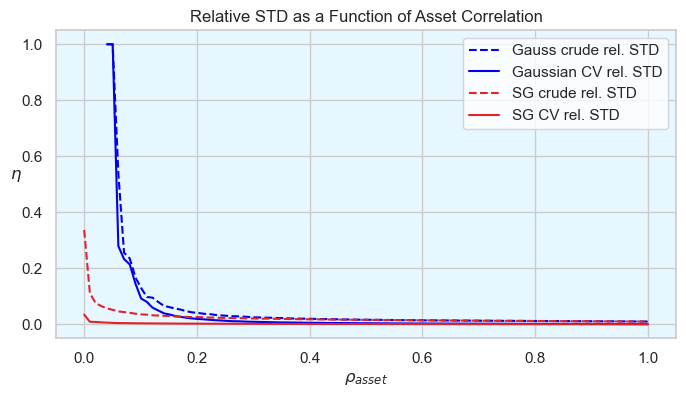

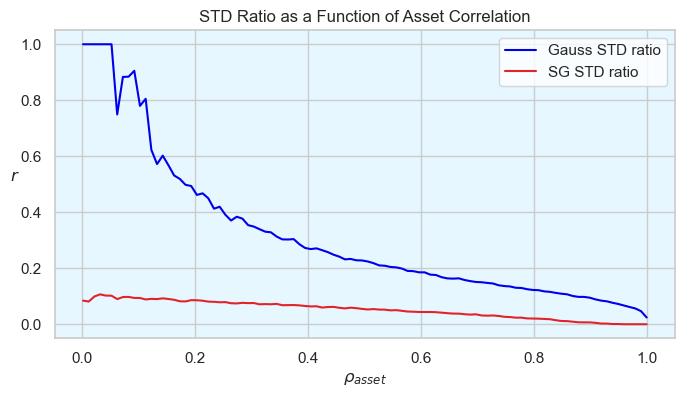

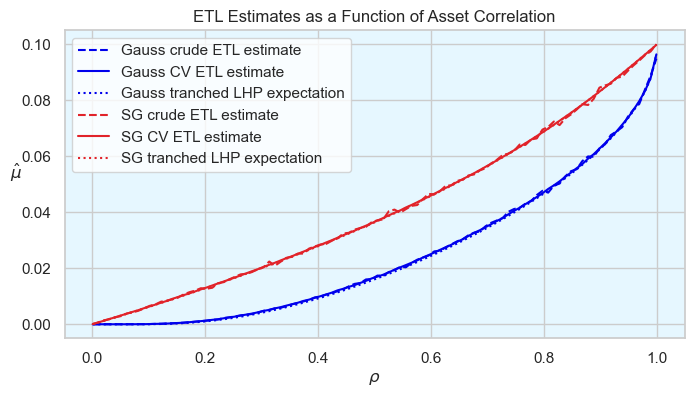

In [90]:
# Generate Plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor/mc_ests_gauss_cor, label="Gauss crude rel. STD", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_ests_stds_gauss_cor * np.sqrt(1 - mc_cv_corrs_gauss_cor**2) / mc_cv_ests_gauss_cor, label="Gaussian CV rel. STD", color='#0000EC')

sns.lineplot(x = cor_range, y = mc_ests_stds_sg_cor/mc_ests_sg_cor, label="SG crude rel. STD", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_ests_stds_sg_cor * np.sqrt(1 - mc_cv_corrs_sg_cor**2) / mc_cv_ests_sg_cor, label="SG CV rel. STD", color='#E1232A')
plt.ylabel(r"$\eta$", rotation=0)
plt.xlabel(r"$\rho_{asset}$")
plt.title("Relative STD as a Function of Asset Correlation")
plt.legend()
plt.show()

# Generate Plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)

sns.lineplot(x = cor_range, y = np.sqrt(1 - mc_cv_corrs_gauss_cor**2), label="Gauss STD ratio", color='#0000EC')
sns.lineplot(x = cor_range, y = np.sqrt(1 - mc_cv_corrs_sg_cor**2), label="SG STD ratio", color='#E1232A')

plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$\rho_{asset}$")
plt.title("STD Ratio as a Function of Asset Correlation")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)

sns.lineplot(x = cor_range, y = mc_ests_gauss_cor, label= "Gauss crude ETL estimate", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_cv_ests_gauss_cor, label="Gauss CV ETL estimate", color='#0000EC')
sns.lineplot(x=cor_range, y=tranche_lhp_exact_gauss_cor, label="Gauss tranched LHP expectation", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = cor_range, y = mc_ests_sg_cor, label="SG crude ETL estimate", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = cor_range, y = mc_cv_ests_sg_cor, label="SG CV ETL estimate", color='#E1232A')
sns.lineplot(x=cor_range, y=tranche_lhp_exact_sg_cor, label="SG tranched LHP expectation", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$\rho$")
plt.title("ETL Estimates as a Function of Asset Correlation")
plt.legend()
plt.show()

## Inhomogenous Portfolio Analysis

### Portfolio 1: Two Homogenous Groups 

In [91]:
# Setup Seed and Parameters
np.random.seed(seed)
nr_of_sims = 100000
port_size = 100
a=1
exposures = np.concatenate([np.ones(int(port_size/2)), np.ones(int(port_size/2))*0.02])
exp_weights = exposures / exposures.sum()
pds = np.reshape(np.concatenate([np.ones(int(port_size/2))*0.01, np.ones(int(port_size/2))*0.5]), (1, port_size))
pd_mean = np.inner(pds, exp_weights)[0]
cor = 0.3
d = 1
xd = -np.infty

In [92]:
# Set Seed and Range
np.random.seed(seed)
c_range = np.linspace(0.01, 0.4, 100)

# Initialize Data
crude_ests_gauss_p1 = []
crude_stds_gauss_p1 = []
cv_inhom_ests_gauss_p1 = []
cv_hom_ests_gauss_p1 = []
corrs_inhom_gauss_p1 = []
corrs_hom_gauss_p1 = []
exact_inhom_exp_gauss_p1 = []
exact_hom_exp_gauss_p1 = []
attachment_points_gauss_p1 = []

crude_ests_sg_p1 = []
crude_stds_sg_p1 = []
cv_inhom_ests_sg_p1 = []
cv_hom_ests_sg_p1 = []
corrs_inhom_sg_p1 = []
corrs_hom_sg_p1 = []
exact_inhom_exp_sg_p1 = []
exact_hom_exp_sg_p1 = []
attachment_points_sg_p1 = []

print("Simulating Gaussian Model...")
for c in c_range:
    gauss_func = lambda x: f.cond_el_norm_inhom(x, pds, exp_weights, cor)-c
    xc = fsolve(gauss_func, 0)[0]
    oa_quantities = f.produce_estimates_gauss_inhom(nr_of_sims, port_size, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    exact_exp_inhom = oa_quantities[5]
    exact_exp_hom = oa_quantities[6]
    crude_ests_gauss_p1.append(tranche_losses.mean())
    crude_stds_gauss_p1.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_gauss_p1.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_gauss_p1.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_gauss_p1.append(est_corr_inhom)
    corrs_hom_gauss_p1.append(est_corr_hom)
    exact_inhom_exp_gauss_p1.append(exact_exp_inhom)
    exact_hom_exp_gauss_p1.append(exact_exp_hom)
    attachment_points_gauss_p1.append(c)

print("Simulating shifted gamma Model")
for c in c_range:
    sg_func = lambda x: f.cond_pd_sg_inhom(x, a, pds, exp_weights, cor)-c
    xc  = fsolve(sg_func, 0)[0]
    oa_quantities = f.produce_estimates_sg_inhom(nr_of_sims, port_size, a, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    lhp_tranche_losses_exact_mean_inhom = oa_quantities[5]
    lhp_tranche_losses_exact_mean_hom = oa_quantities[6]
    crude_ests_sg_p1.append(tranche_losses.mean())
    crude_stds_sg_p1.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_sg_p1.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_sg_p1.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_sg_p1.append(est_corr_inhom)
    corrs_hom_sg_p1.append(est_corr_hom)
    exact_inhom_exp_sg_p1.append(lhp_tranche_losses_exact_mean_inhom)
    exact_hom_exp_sg_p1.append(lhp_tranche_losses_exact_mean_hom)
    attachment_points_sg_p1.append(c)

# Transform into arrays
crude_ests_gauss_p1 = np.array(crude_ests_gauss_p1)
crude_stds_gauss_p1 = np.array(crude_stds_gauss_p1)
cv_inhom_ests_gauss_p1 = np.array(cv_inhom_ests_gauss_p1)
cv_hom_ests_gauss_p1 = np.array(cv_hom_ests_gauss_p1)
corrs_inhom_gauss_p1 = np.array(corrs_inhom_gauss_p1)
corrs_hom_gauss_p1 = np.array(corrs_hom_gauss_p1)
exact_inhom_exp_gauss_p1 = np.array(exact_inhom_exp_gauss_p1)
exact_hom_exp_gauss_p1 = np.array(exact_hom_exp_gauss_p1)
attachment_points_gauss_p1 = np.array(attachment_points_gauss_p1)

crude_ests_sg_p1 = np.array(crude_ests_sg_p1)
crude_stds_sg_p1 = np.array(crude_stds_sg_p1)
cv_inhom_ests_sg_p1 = np.array(cv_inhom_ests_sg_p1)
cv_hom_ests_sg_p1 = np.array(cv_hom_ests_sg_p1)
corrs_inhom_sg_p1 = np.array(corrs_inhom_sg_p1)
corrs_hom_sg_p1 = np.array(corrs_hom_sg_p1)
exact_inhom_exp_sg_p1 = np.array(exact_inhom_exp_sg_p1)
exact_hom_exp_sg_p1 = np.array(exact_hom_exp_sg_p1)
attachment_points_sg_p1 = np.array(attachment_points_sg_p1)

Simulating Gaussian Model...
Simulating shifted gamma Model


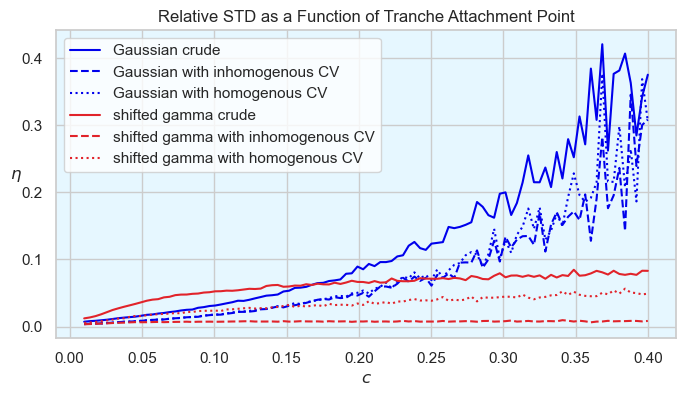

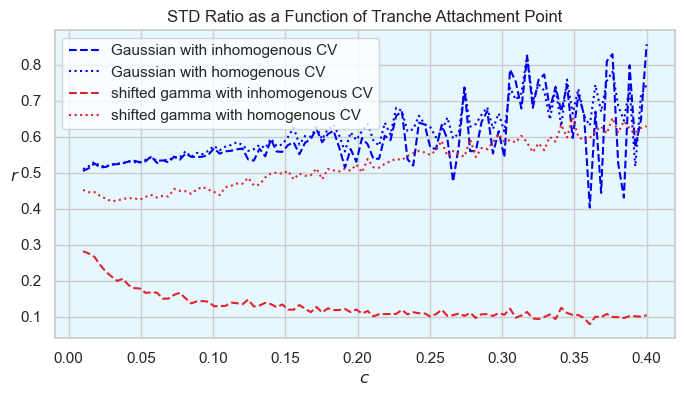

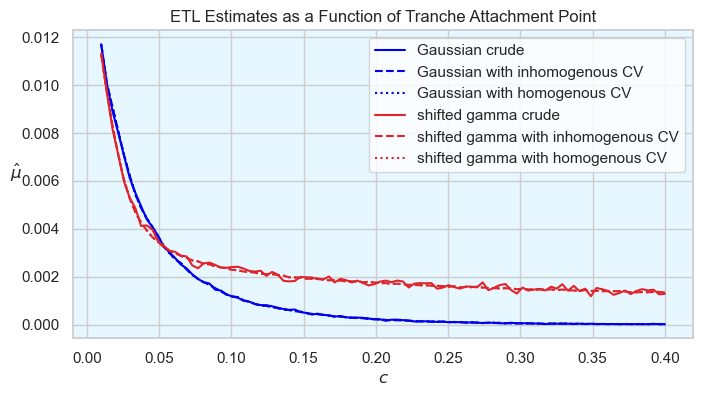

In [93]:
# Generate Plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = crude_stds_gauss_p1/crude_ests_gauss_p1, label="Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = crude_stds_gauss_p1 * np.sqrt(1 - corrs_inhom_gauss_p1**2) / cv_inhom_ests_gauss_p1, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_gauss_p1 * np.sqrt(1 - corrs_hom_gauss_p1**2) / cv_hom_ests_gauss_p1, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = crude_stds_sg_p1/crude_ests_sg_p1, label="shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = crude_stds_sg_p1 * np.sqrt(1 - corrs_inhom_sg_p1**2) / cv_inhom_ests_sg_p1, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_sg_p1 * np.sqrt(1 - corrs_hom_sg_p1**2) / cv_hom_ests_sg_p1, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.title("Relative STD as a Function of Tranche Attachment Point")
plt.xlabel(r"$c$")
plt.ylabel(r"$\eta$",rotation=0)
plt.legend()
plt.show()

# Generate Plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_gauss_p1**2), label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_gauss_p1**2), label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_sg_p1**2), label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_sg_p1**2), label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
plt.title("STD Ratio as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = crude_ests_gauss_p1, label= "Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = cv_inhom_ests_gauss_p1, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_hom_ests_gauss_p1, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = crude_ests_sg_p1, label= "shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p1, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p1, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
plt.title("ETL Estimates as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

### Portfolio 2: Uniform exposures and PDs

In [94]:
# Set Seed and Parameters
np.random.seed(seed)
nr_of_sims = 100000
port_size = 100
a=1
exposures = np.random.uniform(0,1,port_size)
exp_weights = exposures / np.sum(exposures)
pds = np.random.uniform(0, 0.2, (1, port_size))
pd_mean = np.inner(pds, exp_weights)[0]
cor = 0.3
d = 1
xd = -np.infty

In [95]:
# Set Seed and Range
np.random.seed(seed)
c_range = np.linspace(0.01, 0.4, 100)

# Initialize Data
crude_ests_gauss_p2 = []
crude_stds_gauss_p2 = []
cv_inhom_ests_gauss_p2 = []
cv_hom_ests_gauss_p2 = []
corrs_inhom_gauss_p2 = []
corrs_hom_gauss_p2 = []
exact_inhom_exp_gauss_p2 = []
exact_hom_exp_gauss_p2 = []
attachment_points_gauss_p2 = []

crude_ests_sg_p2 = []
crude_stds_sg_p2 = []
cv_inhom_ests_sg_p2 = []
cv_hom_ests_sg_p2 = []
corrs_inhom_sg_p2 = []
corrs_hom_sg_p2 = []
exact_inhom_exp_sg_p2 = []
exact_hom_exp_sg_p2 = []
attachment_points_sg_p2 = []

print("Simulating Gaussian Model...")
for c in c_range:
    gauss_func = lambda x: f.cond_el_norm_inhom(x, pds, exp_weights, cor)-c
    xc = fsolve(gauss_func, 0)[0]
    oa_quantities = f.produce_estimates_gauss_inhom(nr_of_sims, port_size, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    exact_exp_inhom = oa_quantities[5]
    exact_exp_hom = oa_quantities[6]
    crude_ests_gauss_p2.append(tranche_losses.mean())
    crude_stds_gauss_p2.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_gauss_p2.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_gauss_p2.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_gauss_p2.append(est_corr_inhom)
    corrs_hom_gauss_p2.append(est_corr_hom)
    exact_inhom_exp_gauss_p2.append(exact_exp_inhom)
    exact_hom_exp_gauss_p2.append(exact_exp_hom)
    attachment_points_gauss_p2.append(c)

print("Simulating shifted gamma Model")
for c in c_range:
    sg_func = lambda x: f.cond_pd_sg_inhom(x, a, pds, exp_weights, cor)-c
    xc  = fsolve(sg_func, 0)[0]
    oa_quantities = f.produce_estimates_sg_inhom(nr_of_sims, port_size, a, pds, exp_weights, cor, c, d, xc, xd)
    tranche_losses = oa_quantities[0]
    cv_adjusted_tranche_losses_inhom = oa_quantities[1]
    cv_adjusted_tranche_losses_hom = oa_quantities[2]
    est_corr_inhom = oa_quantities[3]
    est_corr_hom = oa_quantities[4]
    lhp_tranche_losses_exact_mean_inhom = oa_quantities[5]
    lhp_tranche_losses_exact_mean_hom = oa_quantities[6]
    crude_ests_sg_p2.append(tranche_losses.mean())
    crude_stds_sg_p2.append(tranche_losses.std()/np.sqrt(nr_of_sims))
    cv_inhom_ests_sg_p2.append(cv_adjusted_tranche_losses_inhom.mean())
    cv_hom_ests_sg_p2.append(cv_adjusted_tranche_losses_hom.mean())
    corrs_inhom_sg_p2.append(est_corr_inhom)
    corrs_hom_sg_p2.append(est_corr_hom)
    exact_inhom_exp_sg_p2.append(lhp_tranche_losses_exact_mean_inhom)
    exact_hom_exp_sg_p2.append(lhp_tranche_losses_exact_mean_hom)
    attachment_points_sg_p2.append(c)

# Transform into Arrays
crude_ests_gauss_p2 = np.array(crude_ests_gauss_p2)
crude_stds_gauss_p2 = np.array(crude_stds_gauss_p2)
cv_inhom_ests_gauss_p2 = np.array(cv_inhom_ests_gauss_p2)
cv_hom_ests_gauss_p2 = np.array(cv_hom_ests_gauss_p2)
corrs_inhom_gauss_p2 = np.array(corrs_inhom_gauss_p2)
corrs_hom_gauss_p2 = np.array(corrs_hom_gauss_p2)
exact_inhom_exp_gauss_p2 = np.array(exact_inhom_exp_gauss_p2)
exact_hom_exp_gauss_p2 = np.array(exact_hom_exp_gauss_p2)
attachment_points_gauss_p2 = np.array(attachment_points_gauss_p2)

crude_ests_sg_p2 = np.array(crude_ests_sg_p2)
crude_stds_sg_p2 = np.array(crude_stds_sg_p2)
cv_inhom_ests_sg_p2 = np.array(cv_inhom_ests_sg_p2)
cv_hom_ests_sg_p2 = np.array(cv_hom_ests_sg_p2)
corrs_inhom_sg_p2 = np.array(corrs_inhom_sg_p2)
corrs_hom_sg_p2 = np.array(corrs_hom_sg_p2)
exact_inhom_exp_sg_p2 = np.array(exact_inhom_exp_sg_p2)
exact_hom_exp_sg_p2 = np.array(exact_hom_exp_sg_p2)
attachment_points_sg_p2 = np.array(attachment_points_sg_p2)

Simulating Gaussian Model...
Simulating shifted gamma Model


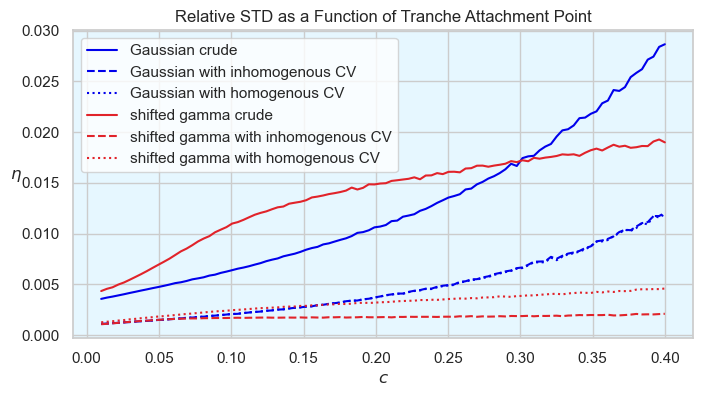

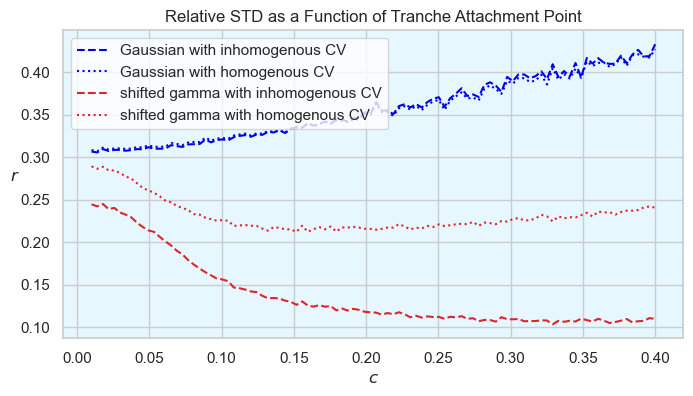

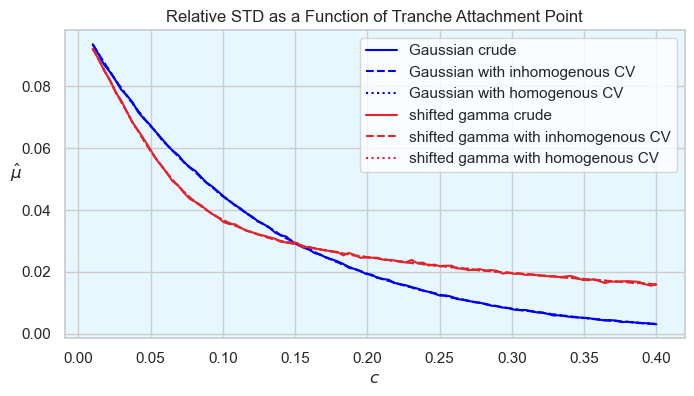

In [96]:
# Generate Plot Relative STD
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF'
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = crude_stds_gauss_p2/crude_ests_gauss_p2, label="Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = crude_stds_gauss_p2 * np.sqrt(1 - corrs_inhom_gauss_p2**2) / cv_inhom_ests_gauss_p2, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_gauss_p2 * np.sqrt(1 - corrs_hom_gauss_p2**2) / cv_hom_ests_gauss_p2, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = crude_stds_sg_p2/crude_ests_sg_p2, label="shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = crude_stds_sg_p2 * np.sqrt(1 - corrs_inhom_sg_p2**2) / cv_inhom_ests_sg_p2, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = crude_stds_sg_p2 * np.sqrt(1 - corrs_hom_sg_p2**2) / cv_hom_ests_sg_p2, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.title("Relative STD as a Function of Tranche Attachment Point")
plt.xlabel(r"$c$")
plt.ylabel(r"$\eta$",rotation=0)
plt.legend()
plt.show()

# Generate Plot STD ratio
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'}) 
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_gauss_p2**2), label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_gauss_p2**2), label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_inhom_sg_p2**2), label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = np.sqrt(1 - corrs_hom_sg_p2**2), label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$r$", rotation=0)
plt.xlabel(r"$c$")
plt.title("Relative STD as a Function of Tranche Attachment Point")
plt.legend()
plt.show()

# Generate Plot ETL estimates
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.color': '0.8'})  
plt.figure(figsize=(8, 4))
background_color = '#E6F7FF' 
plt.gca().set_facecolor(background_color)
sns.lineplot(x = c_range, y = crude_ests_gauss_p2, label= "Gaussian crude", color='#0000EC')
sns.lineplot(x = c_range, y = cv_inhom_ests_gauss_p2, label="Gaussian with inhomogenous CV", color='#0000EC', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_hom_ests_gauss_p2, label="Gaussian with homogenous CV", color='#0000EC', linestyle = "dotted")
sns.lineplot(x = c_range, y = crude_ests_sg_p2, label= "shifted gamma crude", color='#E1232A')
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p2, label="shifted gamma with inhomogenous CV", color='#E1232A', linestyle = "dashed")
sns.lineplot(x = c_range, y = cv_inhom_ests_sg_p2, label="shifted gamma with homogenous CV", color='#E1232A', linestyle = "dotted")
plt.ylabel(r"$\hat\mu$", rotation=0)
plt.xlabel(r"$c$")
plt.title("Relative STD as a Function of Tranche Attachment Point")
plt.legend()
plt.show()